In [2]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
from pyne import data, nucname
from pyne.material import Material
import pandas as pd

In [5]:
rdrive = '/mnt/researchdrive/BOX_INTERNAL/opotowsky/'
pkl62 = rdrive + 'not-scaled_nuc62_activities.pkl'
nuc62 = pd.read_pickle(pkl62).drop(columns=['total']).reset_index(drop=True)
nuc62 = nuc62.loc[(nuc62['Burnup'] > 0) & (nuc62['CoolingTime'] > 0)]

In [5]:
#before filtering for 0 burnup/ct: 448390
nuc62.shape

(440594, 70)

In [6]:
list62 = nuc62.columns.tolist()
del list62[0:8]
len(list62)

62

# Get rid of low/zero activity entries

In [17]:
# arbitrary minimum max activity to filter out ultra-low activity (and zero activity) nucs
min_maxact = 1e-7
new_nuclist = []
for nuc in list62:
    maxact = nuc62[nuc].describe()['max']
    if maxact > min_maxact:
        new_nuclist.append(nuc)
#print(len(new_nuclist))
#print(new_nuclist)

In [18]:
# labels removed
nuc49 = nuc62[new_nuclist]
nuc49.sample(2)

,ac227,am241,am243,ba133,cd109,ce139,ce144,cf249,cf252,cm243,...,th228,th229,u232,u233,u234,u235,u236,u238,y88,zr93
94515,0.000002,439.4,1.44,0.000334,0.000394,4.601000e-04,8092.0,1.657000e-09,9.622000e-10,1.445,...,0.002074,2.326000e-08,0.002857,0.000014,1.7750,0.019580,0.09102,0.3274,3.004000e-06,0.5241
94115,0.000005,1174.0,204.90,0.159900,0.008476,6.060000e-07,172.9,1.158000e-02,2.096000e-01,28.020,...,0.023950,1.372000e-06,0.024810,0.000008,0.3358,0.000029,0.03454,0.3085,1.999000e-10,2.6410


# replacing PyNE method with a manual version to filter out negative nuclide IDs

In [9]:
def manual_gammas(nuclide):
    parent = nucname.id(nuclide)
    decay_c = data.decay_const(parent)
    energies = data.gamma_energy(parent)
    intensities = data.gamma_photon_intensity(parent)
    children = data.gamma_from_to_byparent(parent)
    decay_children = data.decay_data_children(parent)
    decay_branches = data.decay_photon_branch_ratio_byparent(parent)
    
    gammas_result = []
    for i, c in enumerate(children):
        for j, dc in enumerate(decay_children):
            # here is where we skip negative nuclides
            if c[0] > 0:
                if nucname.zzzaaa(c[0]) == nucname.zzzaaa(dc):
                    gammas_result.append((energies[i][0], decay_c*intensities[i][0]*decay_branches[j][0]))
    return gammas_result

# Plotting Gamma Intensities WRT Energy 

In [19]:
#Choosing idx = 140704 for this analysis
idx = 88087#140704
gamma_dflist = []
for nuc in new_nuclist:
    mat = Material()
    act_bq = nuc49.iloc[idx][nuc] * 3.7e10
    mat.from_activity({nuc : act_bq})
    gamlist = manual_gammas(nuc)
    gamma = pd.DataFrame(gamlist, columns = ['energy', 'intensity'])
    #get gamma intensity in decay/s
    num_atoms = mat.mass * 6.02e23 / data.atomic_mass(nucname.id(nuc))
    gamma['total_intensity'] = num_atoms * gamma['intensity']
    gamma['test_counts'] = gamma['total_intensity'] / act_bq
    gamma['nucID'] = nuc
    gamma['half life (y)'] = data.half_life(nucname.id(nuc)) / 60 / 60 / 24 / 365.25
    gamma_dflist.append(gamma)
all_gammas = pd.concat(gamma_dflist).reset_index(drop=True)

In [20]:
nuc_plot = sorted(all_gammas.nucID.unique())

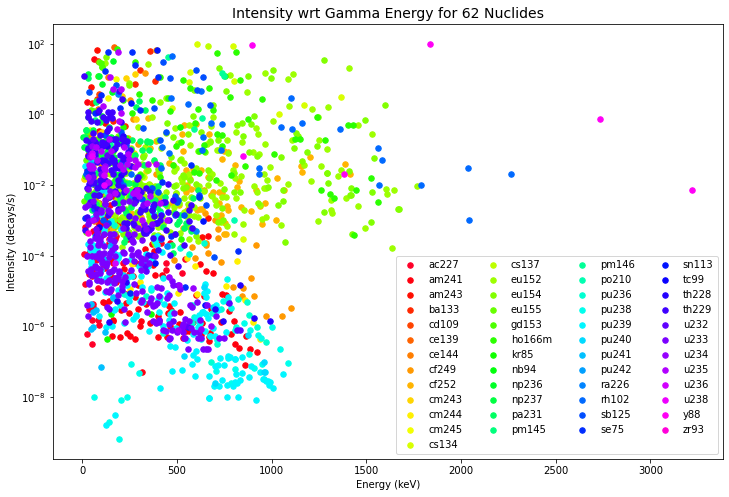

In [21]:
fig, ax = plt.subplots(figsize=(12, 8))
num_colors = len(nuc_plot)
cm = plt.get_cmap('gist_rainbow')
for i, nuc in enumerate(nuc_plot):
    ix = np.where(all_gammas['nucID'] == nuc)
    ax.scatter(all_gammas['energy'].iloc[ix], all_gammas['test_counts'].iloc[ix], 
               color = cm(1.*i/num_colors), label = nuc, s = 30)
#ax.set_ylim(1e1, 1e14)
plt.title('Intensity wrt Gamma Energy for 62 Nuclides', fontsize=14)
plt.yscale('log')
ax.set_xlabel('Energy (keV)')
ax.set_ylabel('Intensity (decays/s)')
ax.legend(loc='best', ncol=4)
plt.show()

In [22]:
some_gammas = all_gammas.loc[(all_gammas['half life (y)'] >= 1.) & (all_gammas['energy'] >= 200)]
# Choosing to move forward with 200 keV cutoff for now since NaI detectors won't see below that. 
# Can add back in more nucs for HPGe detector study but will first attempt to keep it at this list of 32
# No energy cutoff gives full list of 37.

In [23]:
some_nucs = sorted(list(set(some_gammas['nucID'].tolist())))
print(len(some_nucs))
print(some_nucs)

32
['ac227', 'am241', 'am243', 'ba133', 'cf249', 'cf252', 'cm243', 'cm244', 'cm245', 'cs134', 'cs137', 'eu152', 'eu154', 'ho166m', 'kr85', 'nb94', 'np236', 'np237', 'pa231', 'pm146', 'pu236', 'pu238', 'pu239', 'pu240', 'ra226', 'sb125', 'th228', 'th229', 'u232', 'u233', 'u234', 'u235']


In [24]:
for nuc in some_nucs:
    try:
        hl = some_gammas['half life (y)'].loc[some_gammas['nucID'] == nuc].values
        print('{} \t half life  {} years'.format(nuc, hl[0]))
    except:
        print('{} \t not present'.format(nuc))
        some_nucs.remove(nuc)

ac227 	 half life  21.772 years
am241 	 half life  432.59999999999997 years
am243 	 half life  7364.0 years
ba133 	 half life  10.551 years
cf249 	 half life  351.0 years
cf252 	 half life  2.645 years
cm243 	 half life  29.099999999999998 years
cm244 	 half life  18.1 years
cm245 	 half life  8423.0 years
cs134 	 half life  2.0652 years
cs137 	 half life  30.080000000000002 years
eu152 	 half life  13.516999999999998 years
eu154 	 half life  8.600999999999999 years
ho166m 	 half life  1200.0 years
kr85 	 half life  10.739 years
nb94 	 half life  20300.0 years
np236 	 half life  153000.0 years
np237 	 half life  2144000.0 years
pa231 	 half life  32760.0 years
pm146 	 half life  5.529999999999999 years
pu236 	 half life  2.8579999999999997 years
pu238 	 half life  87.7 years
pu239 	 half life  24110.0 years
pu240 	 half life  6561.0 years
ra226 	 half life  1600.0 years
sb125 	 half life  2.75856 years
th228 	 half life  1.9115999999999997 years
th229 	 half life  7880.0 years
u232 	 h

# Finding some target gamma energies for tests

In [21]:
some_gammas['test_counts'].describe()

count    1.065000e+03
mean     1.096067e+00
std      6.706718e+00
min      7.997155e-09
25%      9.996444e-06
50%      1.532139e-03
75%      2.303181e-02
max      9.758499e+01
Name: test_counts, dtype: float64

In [24]:
target_gammas = some_gammas.loc[some_gammas['test_counts'] > 19]
target_gammas.sort_values(by=['test_counts', 'energy'], ascending=False)

,energy,intensity,total_intensity,test_counts,nucID,half life (y)
3471,604.7210,1.038238e-06,2.004269e+14,97.584993,cs134,2.06520
3472,795.8640,9.089102e-07,1.754608e+14,85.429354,cs134,2.06520
3479,661.6570,6.214028e-08,4.614353e+16,85.069738,cs137,30.08000
249,388.1700,4.130079e-09,3.056297e-02,65.976530,cf249,351.00000
213,356.0129,1.291724e-07,1.380922e+07,62.027935,ba133,10.55100
3864,810.2930,1.041118e-09,5.160650e+06,56.859773,ho166m,1200.00000
3857,711.6810,9.910386e-10,4.912416e+06,54.124746,ho166m,1200.00000
4044,453.8300,1.688364e-07,4.406969e+09,42.492784,pm146,5.53000
3773,1274.4290,8.895544e-08,8.320420e+13,34.821342,eu154,8.60100
4368,427.8740,2.356844e-07,5.406174e+13,29.589474,sb125,2.75856


# Evaluating uknown peaks from first rounf of HTC results

In [62]:
en1 = 1209.338
en2 = 1266.063
en3 = 1323.123
en4 = 1365.079
en5 = 1400.322
en6 = 1457.382
en7 = 1591.305
en_err = 0.5
ens = [en1, en2, en3, en4, en5, en6, en7]

In [66]:
pnames = []
matches = []
for i, en in enumerate(ens):
    ps = data.gamma_parent(en, en_err)
    for p in ps:
        if p > 0:
            pname = nucname.name(p)
            pnames.append(pname)
            for nuc in some_nucs:
                if pname.lower() == nuc:
                    matches.append(pname)
    print('Energy #{}: '.format(i+1))
    print('From GADRAS gamma spec: {}'.format(en))
    print('Matches: {}'.format(matches))
    print('PyNE Potential Parents: {}\n'.format(sorted(pnames)))

Energy #1: 
From GADRAS gamma spec: 1209.338
Matches: ['Cf252']
PyNE Potential Parents: ['Ag114', 'Ar45', 'Ba129M', 'Cd117M', 'Cf252', 'Cm248', 'Cr57', 'Cs147', 'Dy155', 'Er161', 'Fm251', 'Fr224', 'Gd147', 'Gd161', 'Ir186', 'Ir188', 'La131', 'Lu171', 'Lu172', 'Mo105', 'Nb88M', 'Os176', 'Pb197', 'Pb199', 'Re188', 'Rh106', 'Rh99', 'Ru105', 'Ru109', 'Sb129', 'Tb152', 'Tl186', 'Xe140', 'Yb165']

Energy #2: 
From GADRAS gamma spec: 1266.063
Matches: ['Cf252']
PyNE Potential Parents: ['Ag114', 'Am238', 'Ar45', 'Au181', 'Au183', 'Au185', 'Au187', 'Ba129M', 'Ba129M', 'Bi201', 'Bi205', 'Cd117M', 'Ce133M', 'Cf252', 'Cm248', 'Cr57', 'Cs147', 'Dy147M', 'Dy155', 'Dy155', 'Er161', 'Eu146', 'Fm251', 'Fr224', 'Gd147', 'Gd161', 'Ge79', 'Hf171', 'Ho150', 'Ir182', 'Ir186', 'Ir188', 'La131', 'Lu171', 'Lu172', 'Mn58M', 'Mo105', 'Nb88M', 'Os176', 'Pb197', 'Pb199', 'Pr145', 'Rb78M', 'Re188', 'Re190M', 'Rh106', 'Rh106', 'Rh99', 'Ru105', 'Ru109', 'Ru111', 'S31', 'S41', 'Sb129', 'Si31', 'Sr93', 'Ta172', 'Tb152'

# Keeping the cells below for reference

## A. Old list only had a small number of nucs with half lives longer than a month

In [80]:
halflifemin = all_gammas.loc[all_gammas['half life (y)'] > 0.1]
hlmin_list = list(set(halflifemin['nucID'].tolist()))
hlmin_list

['cm244',
 'cs137',
 'ce144',
 'zr95',
 'y91',
 'pu241',
 'sr89',
 'pm147',
 'cs134',
 'ru103']

#### Get list of Isos with energy above 300 keV and intensity above 100, then 10 (min half life of ~1 month now applied)

In [93]:
set(all_gammas.loc[(all_gammas['half life (y)'] > 0.1) & (all_gammas['energy'] > 300) & (all_gammas['intensity'] > 100)]['nucID'].tolist())

set()

In [94]:
# ~50 nucs here, 16 above
above10 = set(all_gammas.loc[(all_gammas['half life (y)'] > 0.1) & (all_gammas['energy'] > 300) & (all_gammas['intensity'] >= 10)]['nucID'].tolist())

In [90]:
above10

{'cm244', 'cs134', 'cs137', 'ru103', 'sr89', 'y91', 'zr95'}

In [91]:
len(above10)

7

In [96]:
some_gammas = halflifemin.loc[(all_gammas['energy'] > 300) & (all_gammas['intensity'] >= 10)]
some_gammas

,energy,intensity,nucID,half life (y)
360,302.990,21.400,cm244,18.100000
361,506.900,10.000,cm244,18.100000
362,554.500,100.000,cm244,18.100000
363,597.200,61.000,cm244,18.100000
365,758.600,16.100,cm244,18.100000
366,817.800,80.000,cm244,18.100000
377,569.331,15.373,cs134,2.065200
378,604.721,97.620,cs134,2.065200
379,795.864,85.460,cs134,2.065200
386,661.657,85.100,cs137,30.080000


## B. Find nucs with longer half lives from gadras list

this was done, then new origen sims were run with the new nuclide list. 

those results are now above in nuc62.

In [3]:
gad_file = '/home/opotowsky/gadras_linux_apis/DetectorResponse/gadras_run_directory/RadionuclideList.txt'
filelines = []
with open(gad_file) as f:
    for line in f.readlines():
        l = line.strip().split()
        filelines.append(l)
del filelines[0]
del filelines[143]
gad_nucs = [line[0] for line in filelines]
print(gad_nucs)

['Be7', 'N16', 'F18', 'Na22', 'Na24', 'Si31', 'P32', 'Cl38', 'Ar41', 'K40', 'K42', 'Sc46', 'Cr51', 'Mn54', 'Mn56', 'Fe52', 'Fe59', 'Co56', 'Co57', 'Co58', 'Co60', 'Co62', 'Co62m', 'Ni66', 'Cu64', 'Cu67', 'Zn63', 'Zn65', 'Ga67', 'Ga68', 'Ga72', 'Ge68', 'As76', 'Se75', 'Br77', 'Br82', 'Kr85', 'Kr85m', 'Kr88', 'Rb82', 'Rb83', 'Rb86', 'Sr83', 'Sr85', 'Sr87m', 'Sr89', 'Sr90', 'Sr91', 'Sr92', 'Y88', 'Y92', 'Y93', 'Zr89', 'Zr93', 'Zr95', 'Zr97', 'Nb91', 'Nb91m', 'Nb92', 'Nb92m', 'Nb94', 'Nb95', 'Nb95m', 'Nb97', 'Nb97m', 'Mo99', 'Tc99', 'Tc99m', 'Rh105', 'Ru103', 'Ru105', 'Ru106', 'Rh99', 'Rh100', 'Rh102', 'Rh102m', 'Pd103', 'Ag110m', 'Cd109', 'Cd115', 'In111', 'Sn113', 'Sn125', 'Sb122', 'Sb124', 'Sb125', 'Sb126', 'Te123m', 'Te129', 'Te129m', 'Te132', 'I123', 'I125', 'I126', 'I131', 'I132', 'I133', 'I134', 'I135', 'Xe127', 'Xe129m', 'Xe131m', 'Xe133', 'Xe133m', 'Xe135', 'Cs132', 'Cs134', 'Cs136', 'Cs137', 'Ba133', 'Ba140', 'La138', 'La140', 'Ce139', 'Ce141', 'Ce143', 'Ce144', 'Nd147', 'Pm145',

In [4]:
len(gad_nucs)

196

In [5]:
gammas = []
for nuc in gad_nucs:
    energy = pd.DataFrame(data.gamma_energy(nucname.id(nuc)), columns = ['energy', 'err'])
    intensity = pd.DataFrame(data.gamma_photon_intensity(nucname.id(nuc)), columns = ['intensity', 'err'])
    gamma = pd.concat([energy.iloc[:,0], intensity.iloc[:,0]], axis=1)
    gamma['nucID'] = nuc
    gamma['half life (y)'] = data.half_life(nucname.id(nuc)) / 60 / 60 / 24 / 365.25
    gammas.append(gamma)
gad_gammas = pd.concat(gammas).reset_index(drop=True)

In [6]:
# overwriting dataframe with only nucs that have half life longer than 3 months
gad_gammas = gad_gammas.loc[gad_gammas['half life (y)'] > 0.25]

In [7]:
gadlist = sorted(list(set(gad_gammas['nucID'].tolist())))
print(len(gadlist))
print(gadlist)

62
['Ac227', 'Am241', 'Am243', 'Ba133', 'Bi207', 'Cd109', 'Ce139', 'Ce144', 'Cf249', 'Cf252', 'Cm243', 'Cm244', 'Cm245', 'Co57', 'Co60', 'Cs134', 'Cs137', 'Eu150', 'Eu152', 'Eu154', 'Eu155', 'Gd153', 'Ho166m', 'K40', 'Kr85', 'La138', 'Lu176', 'Mn54', 'Na22', 'Nb92', 'Nb94', 'Np236', 'Np237', 'Pa231', 'Pm145', 'Pm146', 'Po210', 'Pu236', 'Pu238', 'Pu239', 'Pu240', 'Pu241', 'Pu242', 'Ra226', 'Rh102', 'Sb125', 'Se75', 'Sn113', 'Ta182', 'Tc99', 'Th228', 'Th229', 'Th232', 'U232', 'U233', 'U234', 'U235', 'U236', 'U238', 'Y88', 'Zn65', 'Zr93']


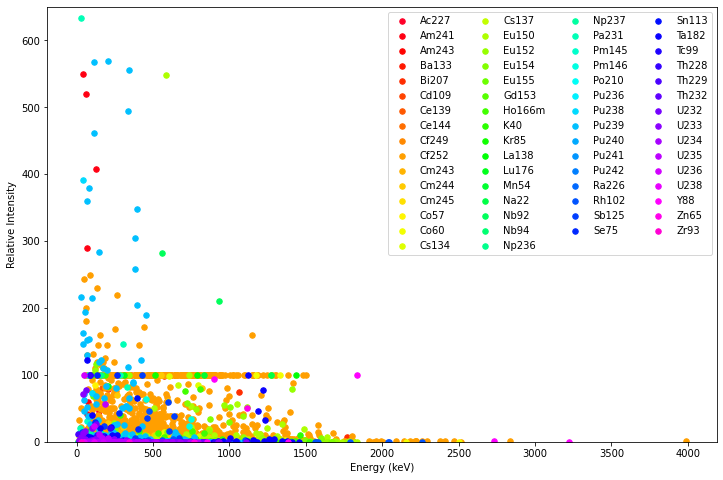

In [11]:
fig, ax = plt.subplots(figsize=(12, 8))

num_colors = len(gadlist)
cm = plt.get_cmap('gist_rainbow')
for i, nuc in enumerate(gadlist):
    ix = np.where(gad_gammas['nucID'] == nuc)
    ax.scatter(gad_gammas['energy'].iloc[ix], gad_gammas['intensity'].iloc[ix], 
               color = cm(1.*i/num_colors), label = nuc, s = 30)
#ax.set_xlim(200, 6000)
ax.set_ylim(0, 650)
ax.set_xlabel('Energy (keV)')
ax.set_ylabel('Relative Intensity')
ax.legend(loc='best', ncol=4)
plt.show()

In [12]:
#gad_min_intensity = set(gad_gammas.loc[(gad_gammas['energy'] > 150) & (gad_gammas['intensity'] >= 5)]['nucID'].tolist())
gad_min_intensity = set(gad_gammas.loc[(gad_gammas['intensity'] >= 1)]['nucID'].tolist())

In [13]:
len(gad_min_intensity)

53

In [14]:
print(list(gad_min_intensity))

['Ac227', 'Rh102', 'Pu241', 'Kr85', 'Ho166m', 'Cd109', 'Cs134', 'Am241', 'Pu239', 'Lu176', 'Cf249', 'K40', 'Co57', 'La138', 'Np237', 'Sn113', 'Nb92', 'Th229', 'Sb125', 'Gd153', 'Pm145', 'Cf252', 'Pa231', 'Np236', 'Y88', 'Cm243', 'Bi207', 'Se75', 'Pu238', 'Eu152', 'U233', 'Na22', 'Am243', 'Ta182', 'Cm245', 'Ce144', 'Eu155', 'U232', 'Mn54', 'Cs137', 'Eu154', 'Zn65', 'Ra226', 'U236', 'Ce139', 'U235', 'Eu150', 'Pm146', 'Ba133', 'Th228', 'Cm244', 'Co60', 'Tc99']


In [16]:
import re

In [25]:
s = 'Cs137'
re.split('(\d+)', s)

['Cs', '137', '']

In [28]:
origen_list = []
for nuc in gadlist:
    splitnuc = re.split('(\d+)', nuc)
    newnuc = splitnuc[0].lower() + '-' + splitnuc[1] + splitnuc[2]
    origen_list.append(newnuc)
for n in origen_list: print(n)

ac-227
am-241
am-243
ba-133
bi-207
cd-109
ce-139
ce-144
cf-249
cf-252
cm-243
cm-244
cm-245
co-57
co-60
cs-134
cs-137
eu-150
eu-152
eu-154
eu-155
gd-153
ho-166m
k-40
kr-85
la-138
lu-176
mn-54
na-22
nb-92
nb-94
np-236
np-237
pa-231
pm-145
pm-146
po-210
pu-236
pu-238
pu-239
pu-240
pu-241
pu-242
ra-226
rh-102
sb-125
se-75
sn-113
ta-182
tc-99
th-228
th-229
th-232
u-232
u-233
u-234
u-235
u-236
u-238
y-88
zn-65
zr-93
